In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import stft
from pzData import pzNpz
from ezPzModels import ezPzLSTM

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

CPU


/home/austin/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
train_labels = "./data/train_labels.csv"
test_labels = "./data/test_labels.csv"
val_labels = "./data/val_labels.csv"
val_dir = test_dir = train_dir = "./data/raw/"

CROP = 12000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, :CROP]
    d = np.fft.fft(x[1, :CROP])
    return np.asarray([t, d])


train_dataset = pzNpz(train_labels, train_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzNpz(test_labels, test_dir, transform=fourier)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzNpz(val_labels, val_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [4]:
# model parameters
input_size = CROP
hidden_size = 128
num_layers = 2
# for now, this is only a binary classification task
num_classes = 2

Validation Accuracy: 55.88%
Average Validation Loss: 0.687
Epoch [1/10], Loss: 0.704
Validation Accuracy: 64.71%
Average Validation Loss: 0.680
Epoch [2/10], Loss: 0.663
Validation Accuracy: 41.18%
Average Validation Loss: 0.733
Epoch [3/10], Loss: 0.519
Validation Accuracy: 61.76%
Average Validation Loss: 0.777
Epoch [4/10], Loss: 0.300
Validation Accuracy: 55.88%
Average Validation Loss: 0.931
Epoch [5/10], Loss: 0.066
Validation Accuracy: 52.94%
Average Validation Loss: 1.299
Epoch [6/10], Loss: 0.006
Validation Accuracy: 50.00%
Average Validation Loss: 1.574
Epoch [7/10], Loss: 0.001
Validation Accuracy: 52.94%
Average Validation Loss: 1.747
Epoch [8/10], Loss: 0.000
Validation Accuracy: 52.94%
Average Validation Loss: 1.857
Epoch [9/10], Loss: 0.000
Validation Accuracy: 52.94%
Average Validation Loss: 1.937
Epoch [10/10], Loss: 0.000


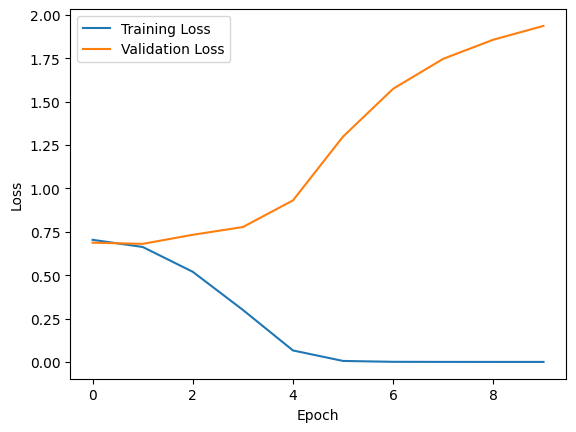

In [20]:
model = ezPzLSTM(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    predicted_y = []
    true_y = []
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_scores = model(val_x)
            val_loss += criterion(val_scores, val_y).item()

            if device == torch.device('cuda'):
                predicted_y.extend(preds.cpu().numpy())
                true_y.extend(val_y.cpu().numpy())
            else:
                predicted_y.extend(preds.numpy())
                true_y.extend(val_y.numpy())
        
        val_accuracy = accuracy_score(true_y, predicted_y)
        print(f'Validation Accuracy: {val_accuracy:.2%}')

        average_val_loss = val_loss / len(val_loader)
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        val_losses.append(average_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# best_accuracy
best_model = model

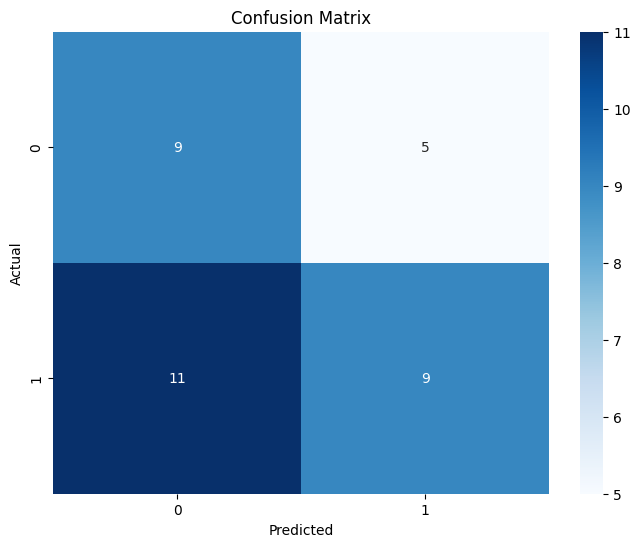

In [21]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
torch.save(best_model, './saved_models/bin_lstm.pth')

In [19]:
ezPiezo = ezPzLSTM
model = torch.load('./saved_models/bin_lstm.pth')
model.eval()

predicted_y = []
true_y = []
val_loss = 0
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device=device, dtype=torch.float32)
        val_y = val_y.to(device=device, dtype=torch.long)
        val_scores = model(val_x)
        _, preds = torch.max(val_scores, 1)
        val_scores = model(val_x)
        val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
    
    val_accuracy = accuracy_score(true_y, predicted_y)
    print(f'Validation Accuracy: {val_accuracy:.2%}')

    average_val_loss = val_loss / len(val_loader)
    print(f'Average Validation Loss: {average_val_loss:.3f}')

Validation Accuracy: 70.59%
Average Validation Loss: 0.563


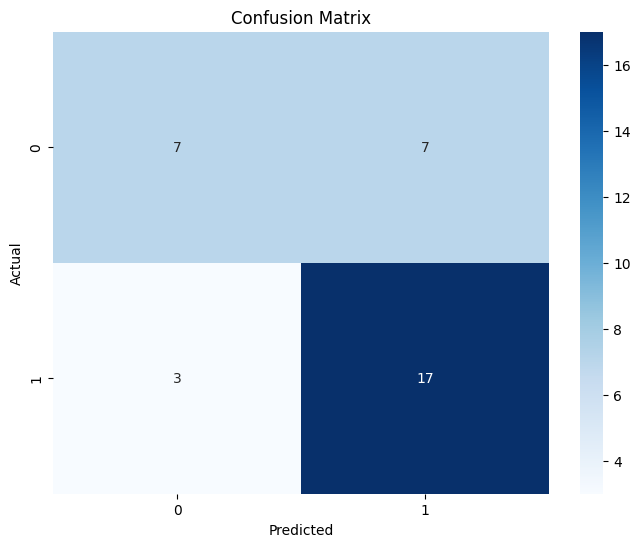

In [18]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Multi-class

In [5]:
train_m = "./data/train_multi.csv"
test_m = "./data/test_multi.csv"
val_m = "./data/val_multi.csv"
data_dir = "./data/raw/"

CROP = 12000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, :CROP]
    d = np.fft.fft(x[1, :CROP])
    return np.asarray([t, d])


train_dataset = pzNpz(train_m, data_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzNpz(test_m, data_dir, transform=fourier)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzNpz(val_m, data_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [6]:
# model parameters
input_size = CROP
hidden_size = 128
num_layers = 2
# classes: Major, minor, Major 7, minor 7
num_classes = 4

Validation Accuracy: 0.0
Epoch [1/10], Loss: 1.3961870272954304
Validation Accuracy: 0.0
Epoch [2/10], Loss: 1.3405459920565288
Validation Accuracy: 0.0
Epoch [3/10], Loss: 1.263542373975118
Validation Accuracy: 0.0
Epoch [4/10], Loss: 1.231119712193807
Validation Accuracy: 0.0
Epoch [5/10], Loss: 1.129360020160675
Validation Accuracy: 0.0
Epoch [6/10], Loss: 1.0404105981190999
Validation Accuracy: 0.25
Epoch [7/10], Loss: 0.9291208982467651
Validation Accuracy: 0.25
Epoch [8/10], Loss: 0.7920613785584768
Validation Accuracy: 0.25
Epoch [9/10], Loss: 0.648011177778244
Validation Accuracy: 0.5
Epoch [10/10], Loss: 0.5167776644229889


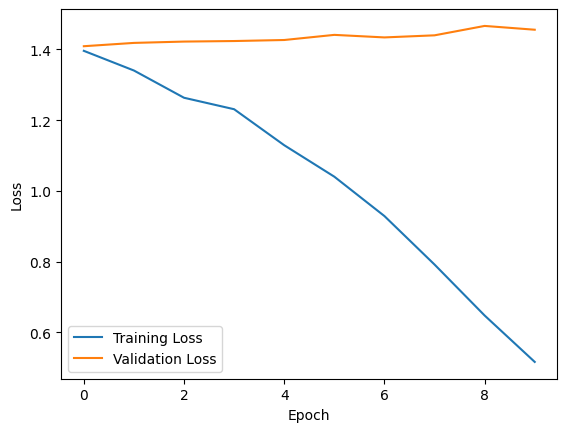

In [12]:
model = ezPzLSTM(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

num_epochs = 10

train_losses = []
val_losses = []
predicted_y = []
true_y = []

# device = torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()

    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_scores = model(val_x)
            val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
        
        val_accuracy = accuracy_score(true_y, predicted_y)
        print(f'Validation Accuracy: {val_accuracy:.2%}')

        avg_val_loss = val_loss / len(val_loader)
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

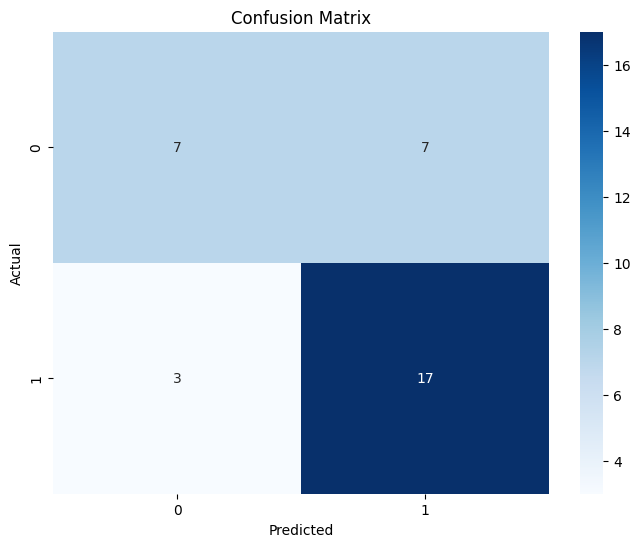

In [32]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()